#### Dataset Loader

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset

class BreakHisDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.samples = []
        self.labels = []

        # Define class mapping
        self.class_to_idx = {'benign': 0, 'malignant': 1}

        # Load all image paths and labels
        for class_name in ['benign', 'malignant']:
            class_dir = os.path.join(data_dir, class_name)
            if not os.path.exists(class_dir):
                raise FileNotFoundError(f" Directory not found: {class_dir}")

            for file_name in os.listdir(class_dir):
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append(os.path.join(class_dir, file_name))
                    self.labels.append(self.class_to_idx[class_name])

        print(f" Loaded {len(self.samples)} images "
              f"(Benign: {self.labels.count(0)}, Malignant: {self.labels.count(1)})")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        label = self.labels[idx]

        # Load image (RGB)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

DATA_DIR = "BreakHis"
dataset = BreakHisDataset(DATA_DIR)

print(f"Total images: {len(dataset)}")


 Loaded 7877 images (Benign: 2454, Malignant: 5423)
Total images: 7877


#### Preprocessing

In [3]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms

# ---- Config ----
IMG_SIZE     = 224
BATCH_SIZE   = 32
SEED         = 42
NUM_WORKERS  = 0                 
PIN_MEMORY   = torch.cuda.is_available()

torch.manual_seed(SEED)
np.random.seed(SEED)

# ---- Transforms 
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.02),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ---- Prepare loaders
def prepare_densenet_data(DATA_DIR):
    torch.manual_seed(SEED)
    np.random.seed(SEED)

    full_dataset = BreakHisDataset(DATA_DIR, transform=None)

    n = len(full_dataset)
    idx = np.arange(n)
    np.random.shuffle(idx)

    train_end = int(0.70 * n)
    val_end   = int(0.85 * n)

    train_idx = idx[:train_end]
    val_idx   = idx[train_end:val_end]
    test_idx  = idx[val_end:]

    train_ds = torch.utils.data.Subset(full_dataset, train_idx)
    val_ds   = torch.utils.data.Subset(full_dataset, val_idx)
    test_ds  = torch.utils.data.Subset(full_dataset, test_idx)

    # attach transforms
    train_ds.dataset.transform = train_transform
    val_ds.dataset.transform   = test_transform
    test_ds.dataset.transform  = test_transform

    # class imbalance handling (compute on train split)
    train_labels = [full_dataset[i][1] for i in train_idx]
    class_counts = np.bincount(train_labels)
    class_weights = 1. / np.maximum(class_counts, 1)
    sample_weights = [class_weights[y] for y in train_labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, sampler=sampler,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
    )
    test_loader = DataLoader(
        test_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
    )

    return train_loader, val_loader, test_loader, train_transform, test_transform

train_loader, val_loader, test_loader, train_transform, test_transform = prepare_densenet_data("BreakHis")


 Loaded 7877 images (Benign: 2454, Malignant: 5423)


#### Feature Extraction

In [4]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchvision import models

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DenseNet-121 backbone
_densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
_densenet_features = _densenet.features.eval().to(DEVICE)
_gap = nn.AdaptiveAvgPool2d((1, 1))

def _forward_blocks(x):
    # DenseNet features order: conv0 -> norm0 -> relu0 -> pool0 -> denseblock1 -> trans1
    # -> denseblock2 -> trans2 -> denseblock3 -> trans3 -> denseblock4 -> norm5
    f = _densenet_features
    x = f.conv0(x); x = f.norm0(x); x = f.relu0(x); x = f.pool0(x)
    x = f.denseblock1(x); x = f.transition1(x)
    x = f.denseblock2(x); x = f.transition2(x)
    x_db3 = f.denseblock3(x)              # DenseBlock3 feature map
    x = f.transition3(x_db3)
    x = f.denseblock4(x); x = f.norm5(x)  # final feature map
    return x_db3, x

@torch.no_grad()
def extract_cnn_features_densenet(dataloader):
    feats_list, labels_list = [], []
    for images, targets in tqdm(dataloader, total=len(dataloader), desc=" DenseNet CNN features"):
        images = images.to(DEVICE, non_blocking=False)

        # forward
        db3, last = _forward_blocks(images)                  # [B, C3, H3, W3], [B, 1024, H, W]
        penultimate = _gap(last).view(images.size(0), -1)    # [B, 1024]
        db3_pool = _gap(db3).view(images.size(0), -1)        # e.g., [B, 512] (DenseBlock3 channels)

        # channel stats on penultimate
        ch_mean = penultimate.mean(dim=1, keepdim=True)
        ch_std  = penultimate.std(dim=1, keepdim=True)
        ch_max  = penultimate.max(dim=1, keepdim=True).values
        ch_min  = penultimate.min(dim=1, keepdim=True).values
        ch_med  = penultimate.median(dim=1, keepdim=True).values

        # spatial pyramid on last map (2x2 and 4x4)
        sp2 = nn.functional.adaptive_avg_pool2d(last, (2,2)).view(images.size(0), -1)
        sp4 = nn.functional.adaptive_avg_pool2d(last, (4,4)).view(images.size(0), -1)
        spp = torch.cat([sp2, sp4], dim=1)                   # [(4+16)*1024]

        # simple channel attention
        weights = torch.sigmoid(penultimate.mean(dim=0, keepdim=True))  # [1,1024]
        att = penultimate * weights

        # contrast feature
        contrast = (ch_max - ch_min)

        # concat all CNN-derived blocks
        combined = torch.cat([
            penultimate,          # 1024
            db3_pool,             # ~512
            ch_mean, ch_std, ch_max, ch_min, ch_med,  # 5 scalars -> 5
            spp,                  # (4+16)*1024 = 20480
            att,                  # 1024
            contrast              # 1
        ], dim=1)

        feats_list.append(combined.cpu().numpy())
        labels_list.append(targets.numpy())

    feats = np.concatenate(feats_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    print(f" CNN features shape: {feats.shape}")
    return feats, labels


train_cnn, y_train = extract_cnn_features_densenet(train_loader)
val_cnn,   y_val   = extract_cnn_features_densenet(val_loader)
test_cnn,  y_test  = extract_cnn_features_densenet(test_loader)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\ranja/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:21<00:00, 1.51MB/s]
 DenseNet CNN features: 100%|██████████| 173/173 [01:14<00:00,  2.32it/s]


 CNN features shape: (5513, 23558)


 DenseNet CNN features: 100%|██████████| 37/37 [00:39<00:00,  1.06s/it]


 CNN features shape: (1182, 23558)


 DenseNet CNN features: 100%|██████████| 37/37 [00:39<00:00,  1.07s/it]

 CNN features shape: (1182, 23558)


#### Feature Engineering

In [5]:
import os, cv2
import pandas as pd
from PIL import Image
from scipy.stats import skew, kurtosis
from scipy.fft import fft2
from skimage import filters, measure
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
import numpy as np
from tqdm import tqdm

def _safe_gray(img_pil):
    g = Image.open(img_pil).convert('L')
    g = np.array(g)
    g = cv2.resize(g, (224, 224))
    g = cv2.GaussianBlur(g, (3,3), 0)
    return cv2.normalize(g, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def _glcm_feats(img):
    glcm = graycomatrix(img, distances=[1,2,3], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)
    feats = []
    for prop in ['contrast','dissimilarity','homogeneity','ASM','energy','correlation']:
        feats.extend(np.ravel(graycoprops(glcm, prop)))
    return feats

def _lbp_hist(img):
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    h, _ = np.histogram(lbp.ravel(), bins=10, range=(0,10))
    return (h / (h.sum() + 1e-8)).tolist()

def _hog_feats(img):
    f, _ = hog(img, pixels_per_cell=(16,16), cells_per_block=(2,2), visualize=True)
    return f[:50].tolist()  # keep first 50 to cap size

def _intensity_feats(img):
    arr = img.astype(np.float32)
    pts = np.percentile(arr, [10,25,75,90])
    return [
        arr.mean(), np.median(arr), arr.std(),
        skew(arr.ravel()), kurtosis(arr.ravel()), np.ptp(arr),
        *pts
    ]

def _edge_grad_feats(img):
    edges = cv2.Canny(img, 100, 200)
    sobelx = filters.sobel_h(img)
    sobely = filters.sobel_v(img)
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    lap_var = cv2.Laplacian(img, cv2.CV_64F).var()
    return [ (edges>0).sum(), grad_mag.mean(), lap_var ]

def _shape_feats(img):
    _, thr = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    lab = measure.label(thr)
    props = measure.regionprops(lab)
    if len(props) == 0:
        return [0]*8
    p = max(props, key=lambda x: x.area)
    return [
        p.area, p.perimeter, p.eccentricity, p.extent, p.solidity,
        p.major_axis_length, p.minor_axis_length, p.orientation
    ]

def _freq_feats(img):
    f = np.abs(fft2(img))
    fshift = np.fft.fftshift(f)
    total = fshift.sum() + 1e-8
    pe = fshift/total
    return [ np.sum(fshift**2), float(-(pe*np.log(pe+1e-12)).sum()) ]

def _haralick_mean(img):
    glcm = graycomatrix(img, distances=[1,2,3], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)
    out = []
    for prop in ['contrast','homogeneity','energy','correlation']:
        out.append(float(graycoprops(glcm, prop).mean()))
    return out

def _stat_moments(img):
    arr = img.astype(np.float32)/255.0
    return [arr.mean(), arr.var(), skew(arr.ravel()), kurtosis(arr.ravel()),
            float((arr**2).sum()), float(-(arr*np.log(arr+1e-12)).sum())]

def extract_engineered_features_from_dir(data_dir):
    rows, labels = [], []
    for cls in ['benign','malignant']:
        cls_dir = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_dir): 
            continue
        for fn in tqdm([f for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))],
                       desc=f" Engineered features: {cls}"):
            path = os.path.join(cls_dir, fn)
            g = _safe_gray(path)

            feats = []
            feats += _glcm_feats(g)
            feats += _lbp_hist(g)
            feats += _hog_feats(g)
            feats += _intensity_feats(g)
            feats += _edge_grad_feats(g)
            feats += _shape_feats(g)
            feats += _freq_feats(g)
            feats += _haralick_mean(g)
            feats += _stat_moments(g)

            rows.append(feats)
            labels.append(0 if cls=='benign' else 1)

    X = np.array(rows, dtype=np.float32)
    y = np.array(labels, dtype=np.int64)
    df = pd.DataFrame(X)
    df['label'] = y
    print(f" Engineered features: {X.shape[1]} per image, {len(y)} samples")
    return df

engineered_df = extract_engineered_features_from_dir(DATA_DIR)

 Engineered features: malignant: 100%|██████████| 5423/5423 [12:32<00:00,  7.21it/s]


 Engineered features: 147 per image, 7877 samples


#### Combine and Normalize Features

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

def _as_array(x):
    if isinstance(x, pd.DataFrame):
        return x.values
    return np.asarray(x)

def _select_engineered(df, drop_cols=("label", "path", "filename")):
    cols = [c for c in df.columns if c not in drop_cols]
    return df[cols]

def _align_by_path(engineered_df, split_paths, path_col="path"):
    if path_col not in engineered_df.columns:
        raise ValueError(f"`{path_col}` column not found in engineered_df.")
    idx = pd.Series(range(len(engineered_df)), index=engineered_df[path_col].astype(str))
    take = []
    missing = 0
    for p in split_paths:
        key = str(p)
        if key in idx:
            take.append(idx[key])
        else:
            take.append(None)
            missing += 1
    if missing:
        print(f"  {missing} engineered rows not found by path; those samples will be dropped.")
    mask = [i is not None for i in take]
    eng_aligned = engineered_df.iloc[[i for i in take if i is not None]].reset_index(drop=True)
    return eng_aligned, np.array(mask, dtype=bool)

def combine_and_normalize_dense(
    # CNN features per split
    train_cnn, val_cnn, test_cnn,
    # Labels per split
    y_train, y_val, y_test,
    # Engineered features DataFrame (must include *at least* columns with features; optional: 'label','path')
    engineered_df: pd.DataFrame,
    # Optional: image paths for alignment (recommended)
    train_paths=None, val_paths=None, test_paths=None, engineered_path_col="path",
    normalize_method="standard",         # "standard" or "minmax"
    apply_pca=True, pca_variance=0.95,   # fit on train, transform val/test
    save_artifacts=True, artifacts_prefix="dense_hybrid"
):
    print(" Combining DenseNet CNN features with engineered features...")

    # Align engineered to each split (preferred)
    if train_paths is not None and val_paths is not None and test_paths is not None:
        eng_train_df, m_train = _align_by_path(engineered_df, train_paths, engineered_path_col)
        eng_val_df,   m_val   = _align_by_path(engineered_df, val_paths,   engineered_path_col)
        eng_test_df,  m_test  = _align_by_path(engineered_df, test_paths,  engineered_path_col)

        # Drop unmatched rows from CNN/labels
        train_cnn, y_train = train_cnn[m_train], np.asarray(y_train)[m_train]
        val_cnn,   y_val   = val_cnn[m_val],     np.asarray(y_val)[m_val]
        test_cnn,  y_test  = test_cnn[m_test],   np.asarray(y_test)[m_test]
    else:
        # Fallback: length-min trim (no path alignment)
        print("ℹ No paths provided — aligning by length (assuming same order in dataset).")
        
        # Get engineered features without label column
        eng_features_only = _select_engineered(engineered_df)
        total_samples = len(eng_features_only)
        
        # Calculate split sizes based on CNN features
        n_train = len(train_cnn)
        n_val = len(val_cnn)
        n_test = len(test_cnn)
        
        # Verify we have enough engineered features
        if total_samples < (n_train + n_val + n_test):
            print(f" Warning: Not enough engineered features ({total_samples}) for all splits ({n_train + n_val + n_test})")
            print("   Using minimum available for each split...")
            n_train = min(n_train, total_samples)
            n_val = min(n_val, max(0, total_samples - n_train))
            n_test = min(n_test, max(0, total_samples - n_train - n_val))
        
        # Split engineered features to match CNN splits
        eng_train_df = engineered_df.iloc[:n_train].reset_index(drop=True)
        eng_val_df = engineered_df.iloc[n_train:n_train+n_val].reset_index(drop=True)
        eng_test_df = engineered_df.iloc[n_train+n_val:n_train+n_val+n_test].reset_index(drop=True)
        
        # Trim CNN and labels to match
        train_cnn, y_train = train_cnn[:n_train], np.asarray(y_train)[:n_train]
        val_cnn, y_val = val_cnn[:n_val], np.asarray(y_val)[:n_val]
        test_cnn, y_test = test_cnn[:n_test], np.asarray(y_test)[:n_test]

    # Strip non-feature columns from engineered
    Xtr_eng = _as_array(_select_engineered(eng_train_df))
    Xva_eng = _as_array(_select_engineered(eng_val_df))
    Xte_eng = _as_array(_select_engineered(eng_test_df))

    # Ensure arrays
    Xtr_cnn, Xva_cnn, Xte_cnn = _as_array(train_cnn), _as_array(val_cnn), _as_array(test_cnn)

    # Concatenate
    Xtr = np.hstack([Xtr_cnn, Xtr_eng])
    Xva = np.hstack([Xva_cnn, Xva_eng])
    Xte = np.hstack([Xte_cnn, Xte_eng])

    print(f" Shapes -> Train: {Xtr.shape}, Val: {Xva.shape}, Test: {Xte.shape}")

    # Normalize (fit only on train)
    scaler = StandardScaler() if normalize_method == "standard" else MinMaxScaler()
    Xtr = scaler.fit_transform(Xtr)
    Xva = scaler.transform(Xva)
    Xte = scaler.transform(Xte)
    print(f" Normalization: {normalize_method}")

    # PCA (fit only on train)
    pca = None
    if apply_pca:
        pca = PCA(n_components=pca_variance, random_state=42)
        Xtr = pca.fit_transform(Xtr)
        Xva = pca.transform(Xva)
        Xte = pca.transform(Xte)
        kept = Xtr.shape[1]
        expv = np.sum(pca.explained_variance_ratio_)
        print(f" PCA: kept {kept} dims (explained variance ≈ {expv:.3f})")

    # Save artifacts for re-use (optional)
    if save_artifacts:
        np.savez_compressed(
            f"{artifacts_prefix}_features_splits.npz",
            X_train=Xtr, y_train=np.asarray(y_train),
            X_val=Xva,   y_val=np.asarray(y_val),
            X_test=Xte,  y_test=np.asarray(y_test)
        )
        # Pickle scaler & PCA safely
        import joblib
        joblib.dump(scaler, f"{artifacts_prefix}_scaler.joblib")
        if pca is not None:
            joblib.dump(pca, f"{artifacts_prefix}_pca.joblib")
        print(f" Saved: {artifacts_prefix}_features_splits.npz, scaler.joblib, pca.joblib")

    return (Xtr, np.asarray(y_train)), (Xva, np.asarray(y_val)), (Xte, np.asarray(y_test)), scaler, pca


(X_train, y_train), (X_val, y_val), (X_test, y_test), scaler, pca = combine_and_normalize_dense(
    train_cnn=train_cnn,
    val_cnn=val_cnn,
    test_cnn=test_cnn,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    engineered_df=engineered_df,
    train_paths=None, 
    val_paths=None,
    test_paths=None,
    engineered_path_col="path",
    normalize_method="standard",
    apply_pca=True,
    pca_variance=0.95,
    save_artifacts=True,
    artifacts_prefix="dense_hybrid"
)

print(f" Final feature shapes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

 Combining DenseNet CNN features with engineered features...
ℹ No paths provided — aligning by length (assuming same order in dataset).
 Shapes -> Train: (5513, 23705), Val: (1182, 23705), Test: (1182, 23705)
 Shapes -> Train: (5513, 23705), Val: (1182, 23705), Test: (1182, 23705)
 Normalization: standard
 Normalization: standard
 PCA: kept 1367 dims (explained variance ≈ 0.950)
 PCA: kept 1367 dims (explained variance ≈ 0.950)
 Saved: dense_hybrid_features_splits.npz, scaler.joblib, pca.joblib
 Final feature shapes: Train=(5513, 1367), Val=(1182, 1367), Test=(1182, 1367)
 Saved: dense_hybrid_features_splits.npz, scaler.joblib, pca.joblib
 Final feature shapes: Train=(5513, 1367), Val=(1182, 1367), Test=(1182, 1367)


#### Model Architecture

In [8]:
import torch
import torch.nn as nn
from torchvision import models

class HybridDenseNetModel(nn.Module):
    def __init__(self, engineered_feature_dim, num_classes=1, freeze_backbone=True):
        super(HybridDenseNetModel, self).__init__()

        self.backbone = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

        # Replace classifier with identity — we'll extract 1024-D features
        num_ftrs = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()

        # Freeze early layers for stability if desired
        if freeze_backbone:
            for name, param in self.backbone.features.named_parameters():
                if "denseblock4" not in name:  # only fine-tune last dense block
                    param.requires_grad = False

        self.engineered_branch = nn.Sequential(
            nn.Linear(engineered_feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2)
        )

        #  Fusion Layer (CNN + Engineered)
        fusion_input_dim = num_ftrs + 128  # 1024 (DenseNet) + 128 (engineered)
        self.classifier = nn.Sequential(
            nn.Linear(fusion_input_dim, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, engineered_features):
        # CNN branch
        cnn_feats = self.backbone(image)              # [B, 1024]
        # Engineered branch
        eng_feats = self.engineered_branch(engineered_features)  # [B, 128]
        # Concatenate both feature spaces
        fused = torch.cat([cnn_feats, eng_feats], dim=1)
        # Final prediction
        out = self.classifier(fused)
        return out

engineered_feature_dim = engineered_df.drop(columns=['label'], errors='ignore').shape[1]
model = HybridDenseNetModel(engineered_feature_dim=engineered_feature_dim, num_classes=1)
model = model.to(DEVICE)
print(model)

HybridDenseNetModel(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05,

#### Training

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# Define device consistently
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training device: {device}")

# ---------- Setup ----------
def setup_training(model, lr=1e-4):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.3, verbose=True)
    from torch.cuda.amp import GradScaler
    scaler = GradScaler()
    return criterion, optimizer, scheduler, scaler

# ---------- Train Epoch ----------
def train_epoch(model, dataloader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    all_probs, all_preds, all_targets = [], [], []

    for batch in dataloader:
        if len(batch) == 3:
            images, eng_features, targets = batch
            eng_features = eng_features.to(device).float()
        else:
            images, targets = batch
            bs = images.size(0)
            in_feats = model.engineered_branch[0].in_features
            eng_features = torch.zeros((bs, in_feats), device=device)

        images  = images.to(device)
        targets = targets.float().unsqueeze(1).to(device)

        optimizer.zero_grad()

        from torch.cuda.amp import autocast
        with autocast():
            outputs = model(images, eng_features)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        probs = torch.sigmoid(outputs).detach().cpu().numpy().ravel()
        preds = (probs > 0.5).astype(int)
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_targets.extend(targets.detach().cpu().numpy().ravel())

    epoch_loss = running_loss / max(1, len(dataloader))
    epoch_acc  = accuracy_score(all_targets, all_preds)
    epoch_f1   = f1_score(all_targets, all_preds, zero_division=0)
    try:
        epoch_auc = roc_auc_score(all_targets, all_probs)
    except:
        epoch_auc = 0.0
    return epoch_loss, epoch_acc, epoch_f1, epoch_auc

def validate_epoch(model, dataloader, criterion, device, return_raw=False):
    model.eval()
    running_loss = 0.0
    all_probs, all_preds, all_targets = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 3:
                images, eng_features, targets = batch
                eng_features = eng_features.to(device).float()
            else:
                images, targets = batch
                bs = images.size(0)
                in_feats = model.engineered_branch[0].in_features
                eng_features = torch.zeros((bs, in_feats), device=device)

            images  = images.to(device)
            targets = targets.float().unsqueeze(1).to(device)

            outputs = model(images, eng_features)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            probs = torch.sigmoid(outputs).detach().cpu().numpy().ravel()
            preds = (probs > 0.5).astype(int)
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_targets.extend(targets.detach().cpu().numpy().ravel())

    epoch_loss = running_loss / max(1, len(dataloader))
    epoch_acc  = accuracy_score(all_targets, all_preds)
    epoch_f1   = f1_score(all_targets, all_preds, zero_division=0)
    try:
        epoch_auc = roc_auc_score(all_targets, all_probs)
    except:
        epoch_auc = 0.0

    if return_raw:
        return epoch_loss, epoch_acc, epoch_f1, epoch_auc, np.array(all_probs), np.array(all_targets)
    return epoch_loss, epoch_acc, epoch_f1, epoch_auc

# ---------- Training Loop ----------
def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device,
    num_epochs=20, patience=5, ckpt_path="best_densenet.pth", target_acc_max=None
):
    best_val_loss = float("inf")
    patience_counter = 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  [],
        "train_f1":   [], "val_f1":   [],
        "train_auc":  [], "val_auc":  []
    }

    print(f"\n Training started")
    print(f"Device: {device} | Batches: train={len(train_loader)} val={len(val_loader)}")

    for epoch in range(num_epochs):
        print(f"\n Epoch [{epoch+1}/{num_epochs}]")

        # Train
        train_loss, train_acc, train_f1, train_auc = train_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        # Validate
        val_loss, val_acc, val_f1, val_auc, val_probs, val_targs = validate_epoch(
            model, val_loader, criterion, device, return_raw=True
        )

        scheduler.step(val_loss)

        # Store history
        history["train_loss"].append(train_loss); history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc);   history["val_acc"].append(val_acc)
        history["train_f1"].append(train_f1);     history["val_f1"].append(val_f1)
        history["train_auc"].append(train_auc);   history["val_auc"].append(val_auc)

        print(f"Train → Loss:{train_loss:.4f} Acc:{train_acc:.4f} F1:{train_f1:.4f} AUC:{train_auc:.4f}")
        print(f"Val   → Loss:{val_loss:.4f} Acc:{val_acc:.4f} F1:{val_f1:.4f} AUC:{val_auc:.4f}")

        # Checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), ckpt_path)
            print(f" Model saved → {ckpt_path}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f" Early stopping at epoch {epoch+1}")
                break

        # Optional target acc
        if target_acc_max is not None and val_acc >= target_acc_max:
            print(f" Target accuracy {target_acc_max:.2f} reached!")
            break

    print("\n Training complete!")
    return history, val_probs, val_targs

# Setup training components
criterion, optimizer, scheduler, scaler = setup_training(model, lr=1e-4)

# Train the model
history, val_probs, val_targets = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler, scaler,
    device, num_epochs=50, patience=6,
    ckpt_path="best_hybrid_densenet.pth",
    target_acc_max=0.95   
)

Training device: cuda

 Training started
Device: cuda | Batches: train=173 val=37

 Epoch [1/50]


c:\Users\ranja\anaconda3\envs\pbl_cuda\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\ranja\AppData\Local\Temp\ipykernel_5572\2860151699.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\ranja\AppData\Local\Temp\ipykernel_5572\2860151699.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ranja\AppData\Local\Temp\ipykernel_5572\2860151699.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train → Loss:0.4008 Acc:0.8126 F1:0.8115 AUC:0.8989
Val   → Loss:1.1774 Acc:0.7386 F1:0.8356 AUC:0.8923
 Model saved → best_hybrid_densenet.pth

 Epoch [2/50]


C:\Users\ranja\AppData\Local\Temp\ipykernel_5572\2860151699.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train → Loss:0.1706 Acc:0.9352 F1:0.9347 AUC:0.9829
Val   → Loss:1.2900 Acc:0.7327 F1:0.7642 AUC:0.8383

 Epoch [3/50]


C:\Users\ranja\AppData\Local\Temp\ipykernel_5572\2860151699.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train → Loss:0.0934 Acc:0.9668 F1:0.9666 AUC:0.9945
Val   → Loss:0.2838 Acc:0.9162 F1:0.9398 AUC:0.9776
 Model saved → best_hybrid_densenet.pth

 Epoch [4/50]


C:\Users\ranja\AppData\Local\Temp\ipykernel_5572\2860151699.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train → Loss:0.0586 Acc:0.9802 F1:0.9802 AUC:0.9975
Val   → Loss:0.2414 Acc:0.9315 F1:0.9501 AUC:0.9750
 Model saved → best_hybrid_densenet.pth

 Epoch [5/50]


C:\Users\ranja\AppData\Local\Temp\ipykernel_5572\2860151699.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train → Loss:0.0408 Acc:0.9871 F1:0.9873 AUC:0.9986
Val   → Loss:0.1421 Acc:0.9577 F1:0.9685 AUC:0.9884
 Model saved → best_hybrid_densenet.pth
 Target accuracy 0.95 reached!

 Training complete!


#### Evaluation

In [10]:
import os, numpy as np, torch
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef,
    brier_score_loss
)

@torch.no_grad()
def evaluate_model(model, loader, device, criterion=None, save_logits=False):
    model.eval()
    all_probs, all_preds, all_targets = [], [], []
    running_loss, n_batches = 0.0, 0

    for batch in loader:
        if len(batch) == 3:
            images, eng, targets = batch
            eng = eng.to(device).float()
        else:
            images, targets = batch
            bs = images.size(0)
            in_feats = model.engineered_branch[0].in_features if hasattr(model, "engineered_branch") else 0
            eng = torch.zeros((bs, in_feats), device=device) if in_feats > 0 else None

        images  = images.to(device)
        targets = targets.float().unsqueeze(1).to(device)

        logits = model(images, eng) if eng is not None else model(images)
        probs  = torch.sigmoid(logits).squeeze(1)
        preds  = (probs > 0.5).long()

        if criterion is not None:
            loss = criterion(logits, targets)
            running_loss += loss.item()
            n_batches += 1

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy().ravel())

    y_true = np.asarray(all_targets)
    y_prob = np.asarray(all_probs)
    y_pred = np.asarray(all_preds)

    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, zero_division=0)
    rec   = recall_score(y_true, y_pred, zero_division=0)
    f1    = f1_score(y_true, y_pred, zero_division=0)
    auc   = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0.0
    bal   = balanced_accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc   = matthews_corrcoef(y_true, y_pred)
    brier = brier_score_loss(y_true, y_prob)

    cm = confusion_matrix(y_true, y_pred)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) else 0.0
    else:
        specificity, tn, fp, fn, tp = 0.0, 0, 0, 0, 0

    metrics = {
        "loss": running_loss / max(1, n_batches) if criterion is not None else None,
        "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc,
        "balanced_accuracy": bal, "specificity": specificity,
        "kappa": kappa, "mcc": mcc, "brier": brier,
        "tp": int(tp), "tn": int(tn), "fp": int(fp), "fn": int(fn),
        "n_samples": int(len(y_true))
    }

    # Threshold analysis (Youden’s J)
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    youden_idx = int(np.argmax(tpr - fpr))
    optimal_thr = float(thr[youden_idx])
    y_opt = (y_prob > optimal_thr).astype(int)
    acc_opt = accuracy_score(y_true, y_opt)

    metrics["optimal_threshold"] = optimal_thr
    metrics["accuracy_at_optimal_threshold"] = acc_opt
    metrics["roc_fpr"] = fpr; metrics["roc_tpr"] = tpr; metrics["roc_thr"] = thr

    print("\n" + "="*64)
    print("COMPREHENSIVE TEST METRICS")
    print("="*64)
    print(f"Accuracy           : {acc:.4f}")
    print(f"Balanced Accuracy  : {bal:.4f}")
    print(f"Precision          : {prec:.4f}")
    print(f"Recall (Sensitivity): {rec:.4f}")
    print(f"Specificity        : {specificity:.4f}")
    print(f"F1-Score           : {f1:.4f}")
    print(f"ROC-AUC            : {auc:.4f}")
    print(f"Cohen's Kappa      : {kappa:.4f}")
    print(f"Matthews CC        : {mcc:.4f}")
    print(f"Brier Score        : {brier:.4f}")
    print(f"\nConfusion Matrix: TP={tp} | TN={tn} | FP={fp} | FN={fn}")
    print(f"\nOptimal threshold (Youden): {optimal_thr:.3f}")
    print(f"Accuracy @ optimal threshold: {acc_opt:.4f}")

    return metrics, y_true, y_pred, y_prob

metrics, y_true, y_pred, y_prob = evaluate_model(model, test_loader, device, criterion=None)



COMPREHENSIVE TEST METRICS
Accuracy           : 0.9560
Balanced Accuracy  : 0.9438
Precision          : 0.9658
Recall (Sensitivity): 0.9727
Specificity        : 0.9150
F1-Score           : 0.9692
ROC-AUC            : 0.9854
Cohen's Kappa      : 0.8923
Matthews CC        : 0.8923
Brier Score        : 0.0360

Confusion Matrix: TP=818 | TN=312 | FP=29 | FN=23

Optimal threshold (Youden): 0.598
Accuracy @ optimal threshold: 0.9552


#### Visualization

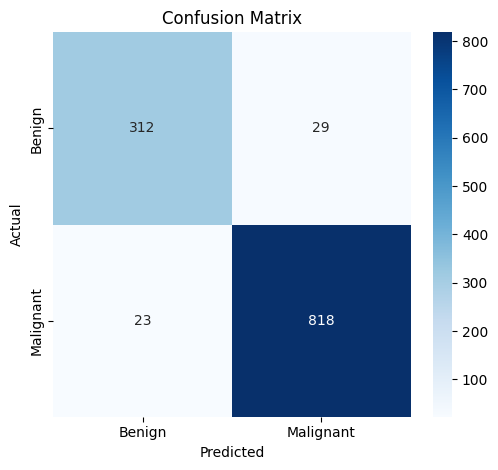

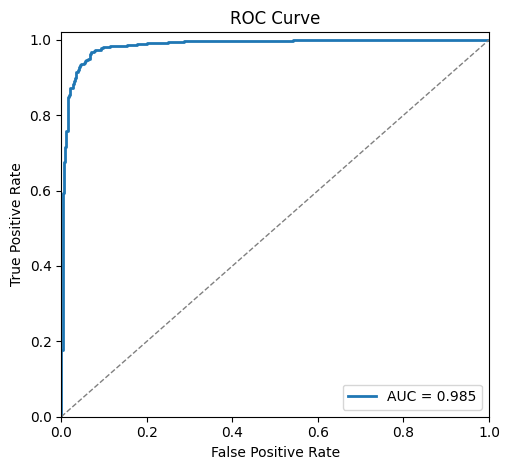

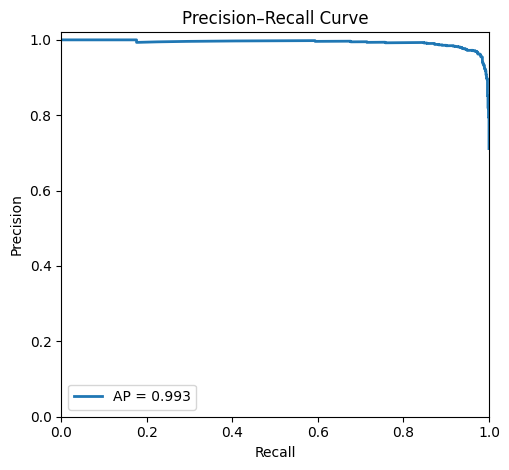

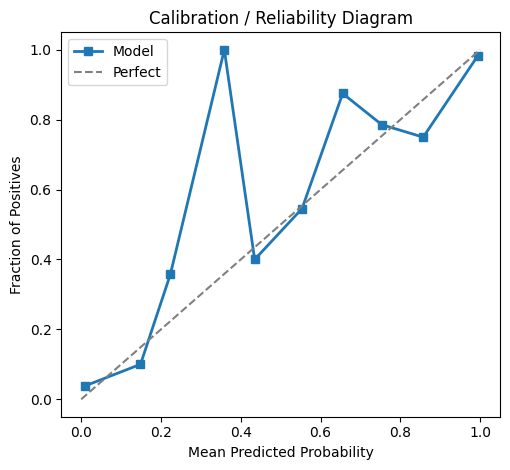

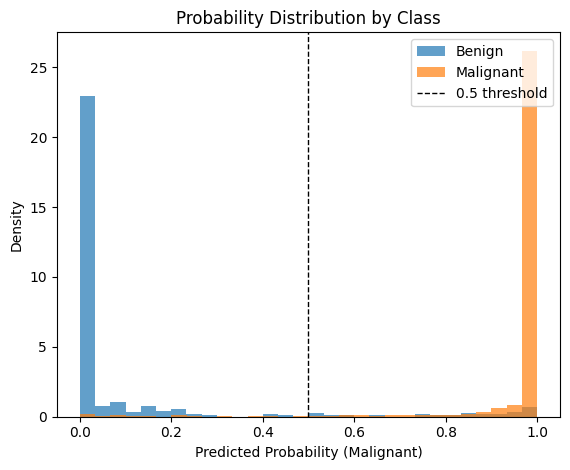

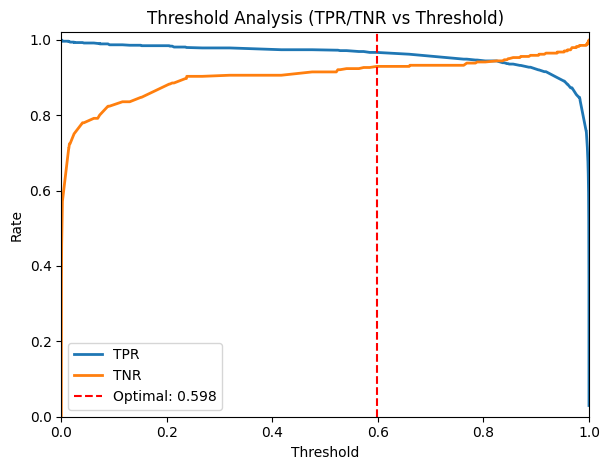

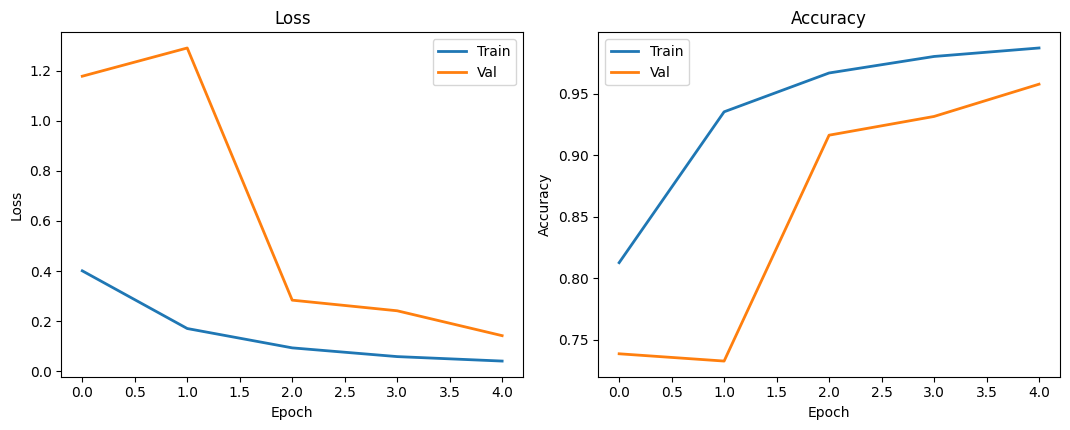


Saved high-dpi figures to: d:\Projects\PBL\figures


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
import os
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, save_dir="figures", fname="cm.png", dpi=300):
    os.makedirs(save_dir, exist_ok=True)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5.2,4.8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign','Malignant'],
                yticklabels=['Benign','Malignant'])
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout(); plt.savefig(os.path.join(save_dir, fname), dpi=dpi); plt.show()

def plot_roc(y_true, y_prob, save_dir="figures", fname="roc.png", dpi=300):
    os.makedirs(save_dir, exist_ok=True)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5.2,4.8))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--',lw=1, color='gray')
    plt.xlim([0,1]); plt.ylim([0,1.02])
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve"); plt.legend(loc="lower right")
    plt.tight_layout(); plt.savefig(os.path.join(save_dir, fname), dpi=dpi); plt.show()

def plot_pr(y_true, y_prob, save_dir="figures", fname="pr.png", dpi=300):
    os.makedirs(save_dir, exist_ok=True)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    plt.figure(figsize=(5.2,4.8))
    plt.plot(recall, precision, lw=2, label=f"AP = {ap:.3f}")
    plt.xlim([0,1]); plt.ylim([0,1.02])
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curve"); plt.legend(loc="lower left")
    plt.tight_layout(); plt.savefig(os.path.join(save_dir, fname), dpi=dpi); plt.show()

def plot_calibration(y_true, y_prob, n_bins=10, save_dir="figures", fname="calibration.png", dpi=300):
    os.makedirs(save_dir, exist_ok=True)
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    plt.figure(figsize=(5.2,4.8))
    plt.plot(prob_pred, prob_true, "s-", lw=2, label="Model")
    plt.plot([0,1],[0,1], "--", color="gray", label="Perfect")
    plt.xlabel("Mean Predicted Probability"); plt.ylabel("Fraction of Positives")
    plt.title("Calibration / Reliability Diagram"); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(save_dir, fname), dpi=dpi); plt.show()

def plot_probability_hist(y_true, y_prob, save_dir="figures", fname="prob_hist.png", dpi=300):
    os.makedirs(save_dir, exist_ok=True)
    benign = y_prob[y_true == 0]; malignant = y_prob[y_true == 1]
    plt.figure(figsize=(5.8,4.8))
    plt.hist(benign, bins=30, alpha=0.7, density=True, label="Benign")
    plt.hist(malignant, bins=30, alpha=0.7, density=True, label="Malignant")
    plt.axvline(0.5, color="k", ls="--", lw=1, label="0.5 threshold")
    plt.xlabel("Predicted Probability (Malignant)"); plt.ylabel("Density")
    plt.title("Probability Distribution by Class"); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(save_dir, fname), dpi=dpi); plt.show()

def plot_threshold_analysis(y_true, y_prob, save_dir="figures", fname="threshold_analysis.png", dpi=300):
    os.makedirs(save_dir, exist_ok=True)
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    youden_idx = np.argmax(tpr - fpr)
    opt_thr = thr[youden_idx]
    plt.figure(figsize=(6.2,4.8))
    plt.plot(thr, tpr, label="TPR", lw=2)
    plt.plot(thr, 1 - fpr, label="TNR", lw=2)
    plt.axvline(opt_thr, color="r", ls="--", lw=1.5, label=f"Optimal: {opt_thr:.3f}")
    plt.xlim([0,1]); plt.ylim([0,1.02])
    plt.xlabel("Threshold"); plt.ylabel("Rate")
    plt.title("Threshold Analysis (TPR/TNR vs Threshold)")
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(save_dir, fname), dpi=dpi); plt.show()

def plot_training_history(history, save_dir="figures", fname="training_curves.png", dpi=300):
    os.makedirs(save_dir, exist_ok=True)
    tr_loss = history.get("train_loss", [])
    va_loss = history.get("val_loss", [])
    tr_acc  = history.get("train_acc",  [])
    va_acc  = history.get("val_acc",  [])

    fig, axes = plt.subplots(1, 2, figsize=(10.8,4.4))
    axes[0].plot(tr_loss, label="Train", lw=2)
    axes[0].plot(va_loss, label="Val", lw=2)
    axes[0].set_title("Loss"); axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss"); axes[0].legend()

    axes[1].plot(tr_acc, label="Train", lw=2)
    axes[1].plot(va_acc, label="Val", lw=2)
    axes[1].set_title("Accuracy"); axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Accuracy"); axes[1].legend()

    plt.tight_layout(); plt.savefig(os.path.join(save_dir, fname), dpi=dpi); plt.show()

def visualize_all(y_true, y_pred, y_prob, history=None, outdir="figures"):
    os.makedirs(outdir, exist_ok=True)
    plot_confusion_matrix(y_true, y_pred, save_dir=outdir, fname="01_confusion_matrix.png")
    plot_roc(y_true, y_prob, save_dir=outdir, fname="02_roc.png")
    plot_pr(y_true, y_prob, save_dir=outdir, fname="03_pr.png")
    plot_calibration(y_true, y_prob, save_dir=outdir, fname="04_calibration.png")
    plot_probability_hist(y_true, y_prob, save_dir=outdir, fname="05_probability_hist.png")
    plot_threshold_analysis(y_true, y_prob, save_dir=outdir, fname="06_threshold_analysis.png")
    if history is not None:
        plot_training_history(history, save_dir=outdir, fname="00_training_curves.png")
    print(f"\nSaved high-dpi figures to: {os.path.abspath(outdir)}")

visualize_all(y_true, y_pred, y_prob, history=history, outdir="figures")

#### Grad-CAM

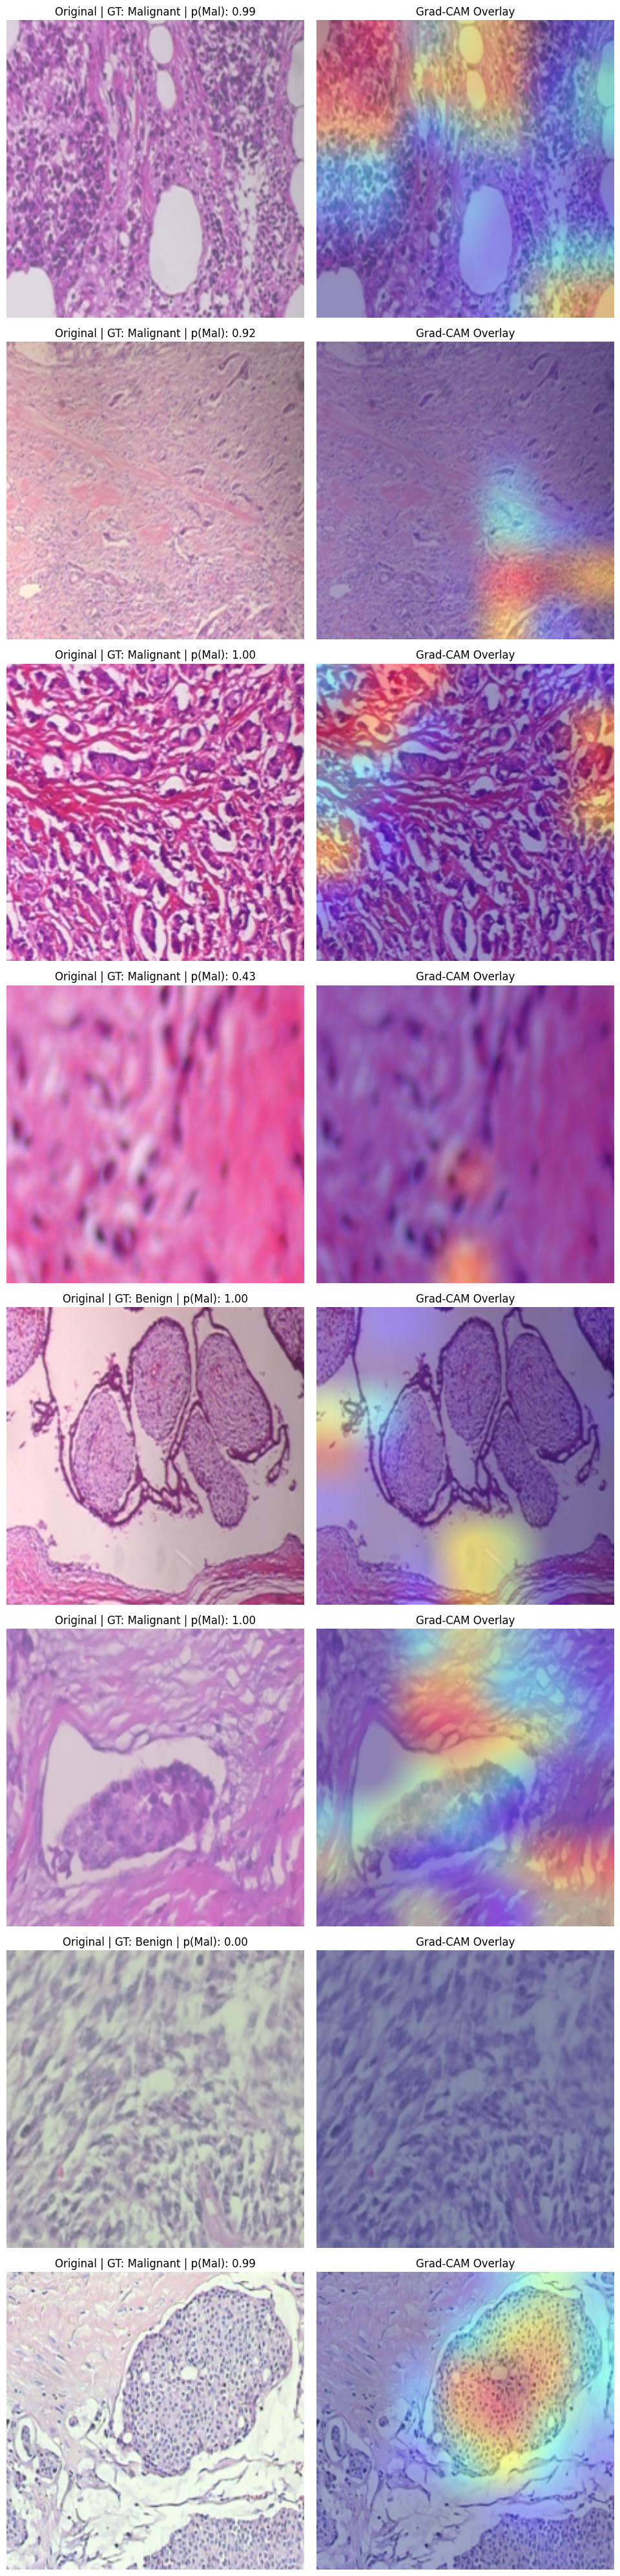

Saved DenseNet Grad-CAM grid → d:\Projects\PBL\figures\07_gradcam_densenet.png


In [19]:
import os, cv2, torch, numpy as np
import torch.nn.functional as F
from torchvision import transforms

# Pick the right last conv block in DenseNet
def _densenet_target_layer(model):
    if hasattr(model, "backbone") and hasattr(model.backbone, "features"):
        feats = model.backbone.features
        if hasattr(feats, "denseblock4"):
            return feats.denseblock4
    if hasattr(model, "features") and hasattr(model.features, "denseblock4"):
        return model.features.denseblock4
    raise RuntimeError("DenseNet target layer not found (expected features.denseblock4).")

class DenseNetGradCAM:
    def __init__(self, model, device="cpu", target_layer=None):
        self.model = model.eval()
        self.device = device
        self.target_layer = target_layer or _densenet_target_layer(model)
        self.activations, self.gradients = None, None

        def fwd_hook(_, __, out): self.activations = out.detach()
        def bwd_hook(_, grad_in, grad_out): self.gradients = grad_out[0].detach()

        self.h1 = self.target_layer.register_forward_hook(fwd_hook)
        self.h2 = self.target_layer.register_full_backward_hook(bwd_hook)

    def remove(self):
        self.h1.remove()
        self.h2.remove()

    def _norm01(self, x):
        x = x - x.min()
        return x / (x.max() + 1e-8)

    def __call__(self, images, targets=None):
        images = images.to(self.device)
        images.requires_grad_(True)

        if getattr(self.model, "engineered_branch", None) is not None:
            bs = images.size(0)
            in_feats = self.model.engineered_branch[0].in_features
            eng = torch.zeros((bs, in_feats), device=self.device)
            logits = self.model(images, eng)
        else:
            logits = self.model(images)

        # Binary head: use malignant probability; else use chosen class prob
        if logits.ndim == 2 and logits.size(1) == 1:
            scores = torch.sigmoid(logits).squeeze(1)
            target_loss = scores
        else:
            probs = torch.softmax(logits, dim=1)
            cls_ids = (targets if targets is not None else probs.argmax(1)).long().to(self.device)
            target_loss = probs[torch.arange(probs.size(0)), cls_ids]

        self.model.zero_grad(set_to_none=True)
        with torch.enable_grad():
            target_loss.sum().backward(retain_graph=True)

        A  = self.activations            # [B, C, H, W]
        dA = self.gradients              # [B, C, H, W]
        w  = dA.mean(dim=(2,3), keepdim=True)   # [B, C, 1, 1]
        cam = (w * A).sum(dim=1)               # [B, H, W]
        cam = F.relu(cam)

        cams = []
        for i in range(cam.size(0)):
            c = self._norm01(cam[i]).cpu().numpy()
            cams.append(c)

        if logits.ndim == 2 and logits.size(1) == 1:
            scores = torch.sigmoid(logits).detach().cpu().numpy().ravel()
        else:
            scores = target_loss.detach().cpu().numpy().ravel()

        return scores, np.stack(cams, axis=0)

def _denorm_to_uint8(img_t):
    inv = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv(img_t.detach().cpu()).clamp(0,1).permute(1,2,0).numpy()
    return (img*255).astype(np.uint8)

def _overlay_heatmap(rgb_uint8, cam2d, alpha=0.35):
    h, w = rgb_uint8.shape[:2]
    heat = cv2.applyColorMap((cam2d*255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    heat = cv2.resize(heat, (w, h), interpolation=cv2.INTER_CUBIC)
    return (alpha*heat + (1-alpha)*rgb_uint8).astype(np.uint8)

def plot_gradcam_densenet_grid(model, loader, device,
                               class_names=('Benign','Malignant'),
                               save_dir="figures", fname="07_gradcam_densenet.png",
                               samples=8, dpi=300, target_layer=None):
    os.makedirs(save_dir, exist_ok=True)
    gcam = DenseNetGradCAM(model, device=device, target_layer=target_layer)

    imgs, overlays, gts, probs = [], [], [], []
    taken = 0
    for batch in loader:
        # accept (img, label) or (img, engineered, label)
        if len(batch) == 3:
            images, _, labels = batch
        else:
            images, labels = batch

        scores, cams = gcam(images, targets=labels)
        for i in range(images.size(0)):
            rgb = _denorm_to_uint8(images[i])
            ov  = _overlay_heatmap(rgb, cams[i])
            imgs.append(rgb); overlays.append(ov)
            gts.append(int(labels[i].cpu().item()))
            probs.append(float(scores[i]))
            taken += 1
            if taken >= samples: break
        if taken >= samples: break

    # Create grid: samples rows × 2 columns (original, overlay)
    rows = len(imgs)
    cols = 2
    plt.figure(figsize=(10, 5*rows))
    for i, (im, ov, gt, p) in enumerate(zip(imgs, overlays, gts, probs)):
        # Original image in left column
        plt.subplot(rows, cols, i*2 + 1)
        plt.imshow(im)
        plt.axis("off")
        plt.title(f"Original | GT: {class_names[gt]} | p(Mal): {p:.2f}")
        
        # Grad-CAM overlay in right column
        plt.subplot(rows, cols, i*2 + 2)
        plt.imshow(ov)
        plt.axis("off")
        plt.title("Grad-CAM Overlay")
    
    plt.tight_layout()
    out_path = os.path.join(save_dir, fname)
    plt.savefig(out_path, dpi=dpi); plt.show()
    gcam.remove()
    print(f"Saved DenseNet Grad-CAM grid → {os.path.abspath(out_path)}")

plot_gradcam_densenet_grid(
    model=model,            # your trained DenseNet (or hybrid DenseNet)
    loader=val_loader,      # or test_loader
    device=device,
    class_names=('Benign','Malignant'),
    save_dir="figures",
    fname="07_gradcam_densenet.png",
    samples=8
)

#### Model Interpretation


 Preparing engineered features for Model Interpretation...
 GPU Memory: 6.44 GB total
 GPU Memory allocated: 0.134 GB
 GPU Memory reserved: 0.359 GB
 Model expects 147 engineered features
 Raw engineered features shape: (7877, 147)
 Val split has 1182 samples
 Val engineered features shape: (1182, 147)
 Built val_features_loader with (images, raw_engineered_features, labels)
  Loader size: 37 batches

 Loader assignments:
 LIME → uses val_loader (images only)
 SHAP & Permutation → use val_features_loader (images + raw engineered features)
RUNNING MODEL INTERPRETATION


100%|██████████| 100/100 [20:55<00:00, 12.55s/it]
C:\Users\ranja\AppData\Local\Temp\ipykernel_5572\3589948386.py:120: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, eval_set, feature_names=feature_names, show=False)

C:\Users\ranja\AppData\Local\Temp\ipykernel_5572\3589948386.py:120: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, eval_set, feature_names=feature_names, show=False)


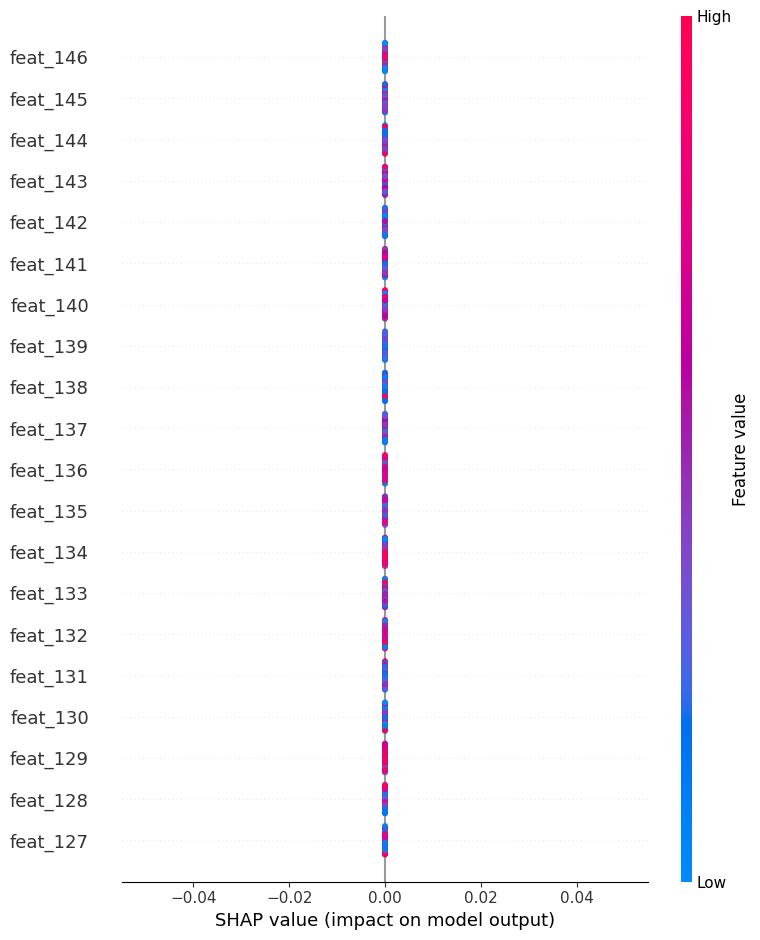

C:\Users\ranja\AppData\Local\Temp\ipykernel_5572\3589948386.py:126: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, eval_set, feature_names=feature_names, plot_type="bar", show=False)


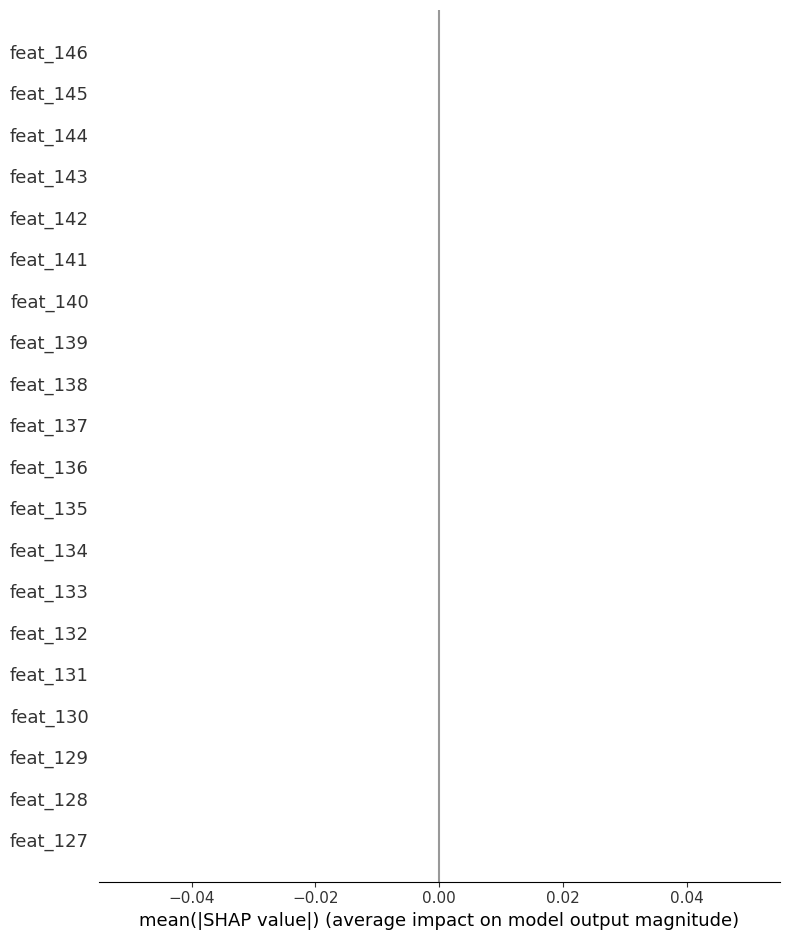

 SHAP plots saved in d:\Projects\PBL\figures\shap


100%|██████████| 1000/1000 [00:05<00:00, 173.40it/s]



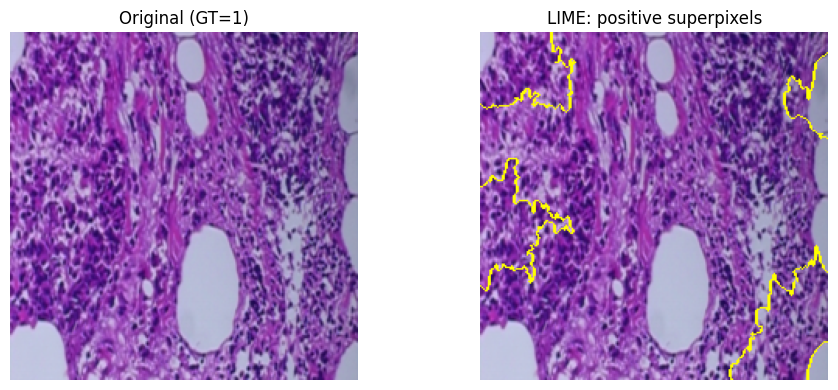

 Saved figures/lime\lime_image_1.png


100%|██████████| 1000/1000 [00:05<00:00, 183.55it/s]



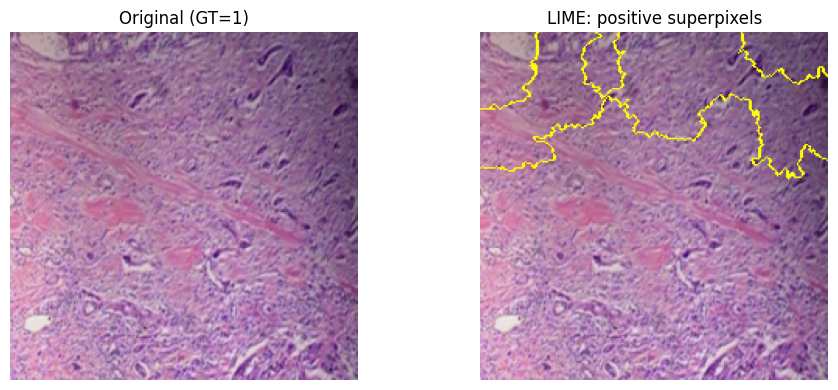

 Saved figures/lime\lime_image_2.png


100%|██████████| 1000/1000 [00:05<00:00, 183.90it/s]



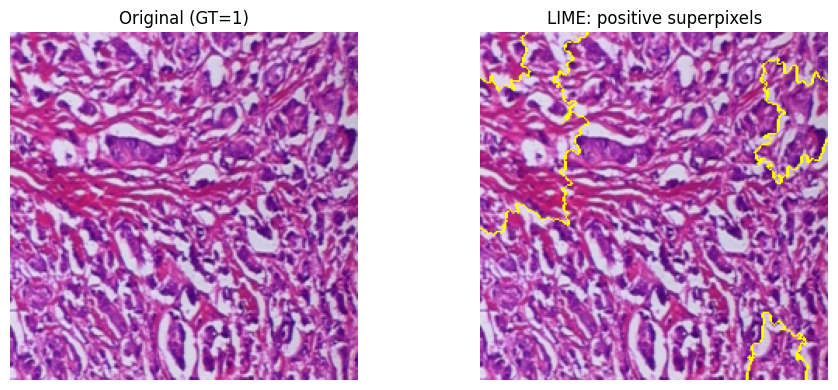

 Saved figures/lime\lime_image_3.png


100%|██████████| 1000/1000 [00:05<00:00, 190.76it/s]



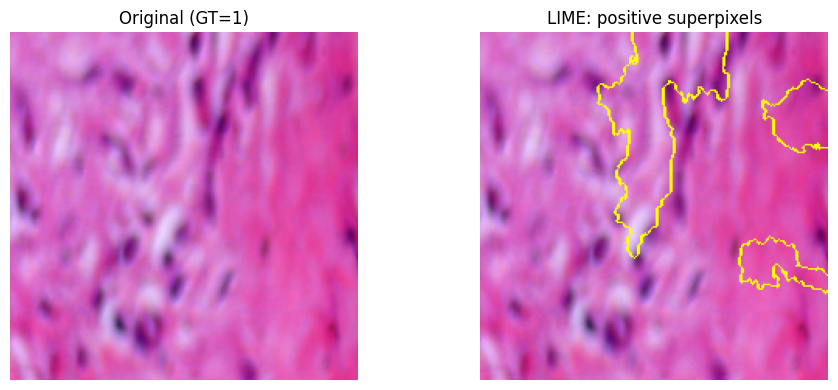

 Saved figures/lime\lime_image_4.png


Permutation importance: 100%|██████████| 147/147 [08:53<00:00,  3.63s/it]



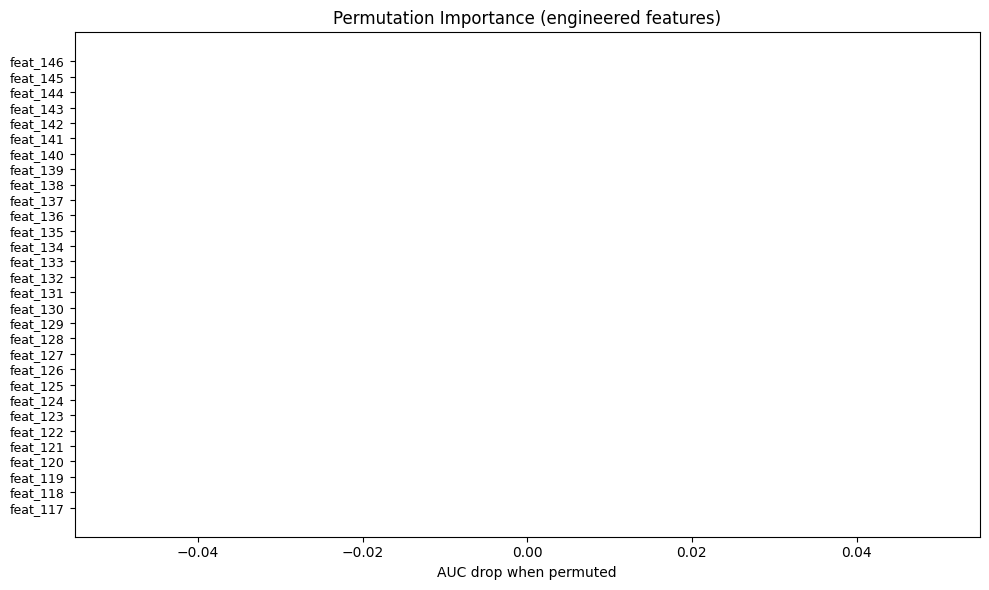

 Saved permutation importance → d:\Projects\PBL\figures\perm_imp\perm_importance_engineered.png (base AUC=0.500)
MODEL INTERPRETATION COMPLETE


In [25]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

def align_array_to_subset(X_full, subset_indices):
    X_full = np.asarray(X_full)
    return X_full[subset_indices]

# FeaturesDataset: Wraps image loader with engineered features
class FeaturesDataset(Dataset):
    def __init__(self, image_subset, engineered_features):
        self.image_subset = image_subset              # torch.utils.data.Subset
        self.engineered_features = torch.as_tensor(engineered_features, dtype=torch.float32)
        if len(self.image_subset) != len(self.engineered_features):
            raise ValueError(f"Len mismatch: subset={len(self.image_subset)} vs eng={len(self.engineered_features)}")
    def __len__(self):
        return len(self.image_subset)
    def __getitem__(self, idx):
        image, label = self.image_subset[idx]
        eng_vec = self.engineered_features[idx]
        return image, eng_vec, label

# Utilities
def _try_get_engineered_dim(model):
    if hasattr(model, "engineered_branch"):
        return model.engineered_branch[0].in_features
    return None

def _model_predict_proba_images(model, imgs_np, device, engineered_dim=None, batch_size=16):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ])
    probs = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(imgs_np), batch_size):
            chunk = imgs_np[i:i+batch_size]
            tens = torch.stack([preprocess(x).float() for x in chunk], dim=0).to(device)
            if hasattr(model, "engineered_branch") and engineered_dim is not None:
                bs = tens.size(0)
                zeros = torch.zeros((bs, engineered_dim), device=device)
                out = model(tens, zeros)
            else:
                out = model(tens)
            p = torch.sigmoid(out).view(-1).detach().cpu().numpy()
            probs.append(p)
    return np.concatenate(probs, axis=0)

def batch_from_loader(loader, max_samples=256):
    imgs, engs, ys = [], [], []
    seen = 0
    for batch in loader:
        if len(batch) == 3:
            x, e, y = batch
            engs.append(e)
        else:
            x, y = batch
        imgs.append(x)
        ys.append(y)
        seen += x.size(0)
        if seen >= max_samples:
            break
    X = torch.cat(imgs, dim=0)
    Y = torch.cat(ys, dim=0)
    E = torch.cat(engs, dim=0) if len(engs) else None
    return X, E, Y

# 1) SHAP for engineered features
def shap_engineered_analysis(model, val_loader_with_features, feature_names=None, save_dir="figures/shap", nsamples=200):
    os.makedirs(save_dir, exist_ok=True)
    X_img, X_eng, y = batch_from_loader(val_loader_with_features, max_samples=512)
    if X_eng is None:
        print(" SHAP skipped: no engineered features available.")
        return

    device = next(model.parameters()).device
    eng_dim = X_eng.shape[1]
    # Use smaller background set to reduce memory usage
    background = X_eng[:min(50, len(X_eng))].detach().cpu().numpy().astype(np.float32)
    eval_set  = X_eng[:min(100, len(X_eng))].detach().cpu().numpy().astype(np.float32)

    def pred_fn(eng_np):
        # Process in smaller batches to avoid OOM
        batch_size = 32
        all_preds = []
        for i in range(0, len(eng_np), batch_size):
            batch_eng = eng_np[i:i+batch_size]
            eng_t = torch.tensor(batch_eng, dtype=torch.float32, device=device)
            bs = eng_t.size(0)
            if hasattr(model, "engineered_branch"):
                img_t = torch.zeros((bs, 3, 224, 224), device=device)
                with torch.no_grad():
                    out = model(img_t, eng_t)
                pred = torch.sigmoid(out).view(-1).detach().cpu().numpy()
            else:
                pred = np.zeros((bs,), dtype=np.float32)
            all_preds.append(pred)
        return np.concatenate(all_preds) if all_preds else np.zeros((len(eng_np),), dtype=np.float32)

    explainer = shap.KernelExplainer(pred_fn, background)
    shap_vals = explainer.shap_values(eval_set, nsamples=nsamples)
    shap_vals = shap_vals if isinstance(shap_vals, np.ndarray) else shap_vals[0]

    if feature_names is None or len(feature_names) != eng_dim:
        feature_names = [f"feat_{i}" for i in range(eng_dim)]

    plt.figure(figsize=(10,6))
    shap.summary_plot(shap_vals, eval_set, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "shap_engineered_summary.png"), dpi=300)
    plt.show()

    plt.figure(figsize=(10,6))
    shap.summary_plot(shap_vals, eval_set, feature_names=feature_names, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "shap_engineered_bar.png"), dpi=300)
    plt.show()
    print(" SHAP plots saved in", os.path.abspath(save_dir))

# 2) LIME (image-level)
def lime_image_explanations(model, val_loader_images_only, samples=4, save_dir="figures/lime"):
    os.makedirs(save_dir, exist_ok=True)
    device = next(model.parameters()).device
    engineered_dim = _try_get_engineered_dim(model)

    xs, es, ys = batch_from_loader(val_loader_images_only, max_samples=samples)
    xs_np = xs.permute(0,2,3,1).detach().cpu().numpy()

    def predict_for_lime(batch_np):
        batch_np = np.clip(batch_np, 0, 1).astype(np.float32)
        p_mal = _model_predict_proba_images(model, batch_np, device, engineered_dim=engineered_dim)
        return np.vstack([1 - p_mal, p_mal]).T

    explainer = lime_image.LimeImageExplainer()
    for i in range(min(samples, xs_np.shape[0])):
        img01 = np.clip((xs_np[i] - xs_np[i].min()) / (xs_np[i].max() - xs_np[i].min() + 1e-8), 0, 1).astype(np.float32)
        exp = explainer.explain_instance(
            img01, predict_for_lime, top_labels=1, hide_color=0, num_samples=1000
        )
        top_label = exp.top_labels[0]
        temp, mask = exp.get_image_and_mask(label=top_label, positive_only=True, num_features=6, hide_rest=False)

        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.imshow(img01); plt.axis("off"); plt.title(f"Original (GT={int(ys[i])})")
        plt.subplot(1,2,2); plt.imshow(mark_boundaries(temp, mask)); plt.axis("off"); plt.title("LIME: positive superpixels")
        out_path = os.path.join(save_dir, f"lime_image_{i+1}.png")
        plt.tight_layout(); plt.savefig(out_path, dpi=300); plt.show()
        print(f" Saved {out_path}")

# 3) Permutation Importance (engineered)
def permutation_importance_engineered(model, val_loader_with_features, n_repeats=5, max_eval=512, save_dir="figures/perm_imp"):
    os.makedirs(save_dir, exist_ok=True)
    X_img, X_eng, y = batch_from_loader(val_loader_with_features, max_samples=max_eval)
    if X_eng is None:
        print(" Permutation importance skipped: no engineered features.")
        return

    device = next(model.parameters()).device
    model.eval()
    eng_dim = X_eng.shape[1]

    @torch.no_grad()
    def _auc(img_t, eng_t, y_t):
        img_t = img_t.to(device)
        eng_t = eng_t.to(device).float()
        out = model(img_t, eng_t) if hasattr(model, "engineered_branch") else model(img_t)
        p = torch.sigmoid(out).view(-1).cpu().numpy()
        return roc_auc_score(y_t.cpu().numpy(), p)

    base_auc = _auc(X_img, X_eng, y)
    drops = np.zeros(eng_dim, dtype=np.float32)

    rng = np.random.default_rng(42)
    for j in tqdm(range(eng_dim), desc="Permutation importance"):
        cur_drop = []
        for _ in range(n_repeats):
            perm = X_eng.clone()
            perm[:, j] = perm[rng.permutation(len(perm)), j]
            auc_p = _auc(X_img, perm, y)
            cur_drop.append(base_auc - auc_p)
        drops[j] = np.mean(cur_drop)

    idx = np.argsort(drops)[::-1][:30]
    names = [f"feat_{i}" for i in range(eng_dim)]
    top_names = [names[i] for i in idx]
    top_vals = drops[idx]

    plt.figure(figsize=(10,6))
    plt.barh(range(len(top_vals)), top_vals[::-1])
    plt.yticks(range(len(top_vals)), top_names[::-1], fontsize=9)
    plt.xlabel("AUC drop when permuted")
    plt.title("Permutation Importance (engineered features)")
    plt.tight_layout()
    out_path = os.path.join(save_dir, "perm_importance_engineered.png")
    plt.savefig(out_path, dpi=300); plt.show()
    print(f" Saved permutation importance → {os.path.abspath(out_path)} (base AUC={base_auc:.3f})")

print("\n Preparing engineered features for Model Interpretation...")

import gc
torch.cuda.empty_cache()
gc.collect()
if torch.cuda.is_available():
    print(f" GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB total")
    print(f" GPU Memory allocated: {torch.cuda.memory_allocated() / 1e9:.3f} GB")
    print(f" GPU Memory reserved: {torch.cuda.memory_reserved() / 1e9:.3f} GB")

expected_eng_dim = model.engineered_branch[0].in_features
print(f" Model expects {expected_eng_dim} engineered features")
engineered_features_raw = engineered_df.drop(columns=['label'], errors='ignore').values
print(f" Raw engineered features shape: {engineered_features_raw.shape}")

# Get val indices from val_loader
val_subset = val_loader.dataset
val_indices = val_subset.indices if hasattr(val_subset, 'indices') else np.arange(len(val_subset))
print(f" Val split has {len(val_indices)} samples")

# Extract engineered features for val split (matching the val_loader order)
val_engineered_raw = engineered_features_raw[val_indices]
print(f" Val engineered features shape: {val_engineered_raw.shape}")

# Verify dimensions match
if val_engineered_raw.shape[1] != expected_eng_dim:
    raise ValueError(f"Dimension mismatch! Model expects {expected_eng_dim} but got {val_engineered_raw.shape[1]}")

# Create FeaturesDataset with correct engineered features
try:
    val_features_dataset = FeaturesDataset(val_subset, engineered_features=val_engineered_raw)
    val_features_loader = DataLoader(
        val_features_dataset,
        batch_size=BATCH_SIZE if 'BATCH_SIZE' in globals() else 32,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    print(" Built val_features_loader with (images, raw_engineered_features, labels)")
    print(f"  Loader size: {len(val_features_loader)} batches")
except Exception as e:
    raise RuntimeError(f"Could not build val_features_loader: {e}")

print("\n Loader assignments:")
print(" LIME → uses val_loader (images only)")
print(" SHAP & Permutation → use val_features_loader (images + raw engineered features)")

# ---- Run Model Interpretation ----
print("RUNNING MODEL INTERPRETATION")

# Use reduced samples to avoid OOM on GPU
shap_engineered_analysis(model, val_features_loader, save_dir="figures/shap", nsamples=100)
lime_image_explanations(model, val_loader, samples=4, save_dir="figures/lime")
permutation_importance_engineered(model, val_features_loader, n_repeats=5, max_eval=256, save_dir="figures/perm_imp")

print("MODEL INTERPRETATION COMPLETE")


#### Model Saving

In [26]:
import torch

# Save model and optimizer
def save_model(model, optimizer=None, path="best_densenet_model.pth", epoch=None, val_loss=None):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict() if optimizer else None,
        "epoch": epoch,
        "val_loss": val_loss,
    }
    torch.save(checkpoint, path)
    print(f" Model saved successfully at: {path}")

# Example usage after training
save_model(model, optimizer, path="best_densenet_model.pth", epoch=50, val_loss=0.12)


 Model saved successfully at: best_densenet_model.pth
